### An ensemble of Neural networks to classify the Fashion MNIST images

In [1]:
from keras.models import load_model
from keras.datasets import fashion_mnist


import numpy as np
import matplotlib.pyplot

/home/lam/anaconda2/envs/tf15/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load the fasion MNIST data

In [2]:
# Load the training and testing data
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
# Display purpose:
X_train_orig = X_train
X_test_orig = X_test

In [3]:
from keras import backend as K
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    shape_ord = (1, img_rows, img_cols)
else:  # channel_last
    shape_ord = (img_rows, img_cols, 1)
    

In [4]:
X_train = X_train.reshape((X_train.shape[0],) + shape_ord)
X_test = X_test.reshape((X_test.shape[0],) + shape_ord)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

## Load the NN models that are already trained

In [5]:
cnn_model = load_model('cnn.h5')
mlff_bp_model = load_model('mlff_bp_model.h5')
rnn_bi_gru_model = load_model('bidirectional_gru.h5')
rnn_bi_gru_model.name = "rnn"
cnn_model2 = load_model('CNN_4.3.6_0.9414.h5')
cnn_model2.name = "cnn 2"

In [6]:
def get_classification_accuracy_ensemble(models_with_accuracy, test_images, test_labels):
    """
    Get the classification accuracy of the models in the ensemble
    """
    models_with_accuracy = [(model, accuracy * 100) for (model, accuracy) in models_with_accuracy if accuracy <= 1]
    
    num_test_images = len(test_images)
    num_test_labels = len(test_labels)
    
    if num_test_images != num_test_labels:
        raise ValueError("The number of test images does not equal the number of test labels.")

    prediction_results = []
    for model, accuracy in models_with_accuracy:
        # print("Accuracy: " + str(accuracy))
        
        # Get arrays (of size 10) of predictions for each test image
        if model.name=="rnn":
            original_predictions = model.predict(np.squeeze(test_images)) # rnn doesn't take in dimension of 1 
        else:
            original_predictions = model.predict(test_images)
        # print(original_predictions)
        
        # multiply each element of predictions for each test image with the accuracy
        weighted_predictions = [accuracy * predictions_for_test_image for predictions_for_test_image in original_predictions]
        # print("Weighted predictions...")
        # print(weighted_predictions)
        prediction_results.append(weighted_predictions)
        
    ensembles_predictions = []
    for itr in range(num_test_images):
        prediction_sum = np.asarray([0.0]*10)
        for prediction_result in prediction_results:
            prediction_sum += (prediction_result[itr])
        # print(prediction_sum)
        ensembles_predictions.append(prediction_sum.argmax(-1))
        
    correct_classifications = 0
    for idx, prediction in enumerate(ensembles_predictions):
        if prediction == test_labels[idx]:
            correct_classifications += 1
            
    print("{0} classified correctly out of {1}. Classification accuracy: {2}".format(correct_classifications, str(num_test_images), correct_classifications/num_test_images))
    return ensembles_predictions

### Get the classification accuracy of the ensemble

In [7]:
slice = 10000
models_with_accuracy = [(cnn_model, 0.9), (rnn_bi_gru_model, 0.89), (mlff_bp_model, 0.88), (cnn_model2, 0.94)]
test_data = X_test[:slice]
test_labels = Y_test[:slice]

ensemble_predictions = get_classification_accuracy_ensemble(models_with_accuracy, test_data, test_labels)

9434 classified correctly out of 10000. Classification accuracy: 0.9434


### Generate the confusion matrix for the predictions

In [8]:
from sklearn.metrics import confusion_matrix

item_label_mapping = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

print(item_label_mapping)
print("Actuals ->")
c = confusion_matrix(Y_test, ensemble_predictions)


print(c)

['T-shirt/Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
Actuals ->
[[928   0   6  15   2   1  40   0   8   0]
 [  0 983   0  12   2   0   2   0   1   0]
 [ 12   0 910   9  40   0  28   0   1   0]
 [ 10   1   4 964  10   0   8   0   3   0]
 [  0   1  36  21 908   0  34   0   0   0]
 [  0   0   0   0   0 986   0  11   0   3]
 [ 68   1  48  19  35   0 823   0   6   0]
 [  0   0   0   0   0   4   0 989   0   7]
 [  1   0   0   5   2   2   0   3 987   0]
 [  0   0   0   0   0   6   0  38   0 956]]


<IPython.core.display.Javascript object>


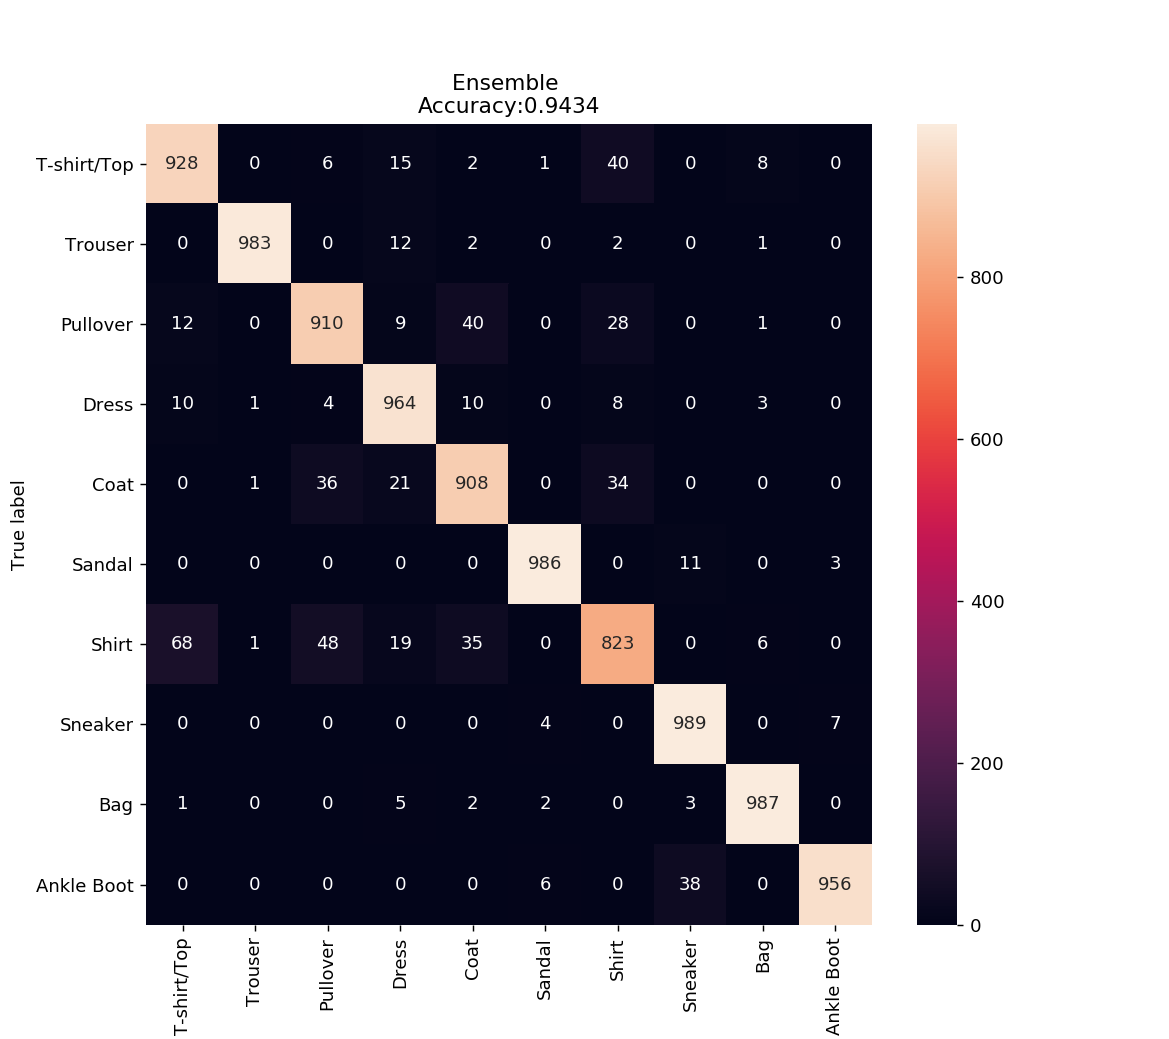

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
f1_score, confusion_matrix, classification_report
%matplotlib notebook

df_cm = pd.DataFrame(c, 
                         index = [i for i in range(0,10)], columns = [i for i in range(0,10)])

plt.figure(figsize=(9,8))
ax_ticks= item_label_mapping
sns.heatmap(df_cm, annot=True, xticklabels=ax_ticks, yticklabels=ax_ticks, fmt='g')
plt.title('Ensemble \nAccuracy:{0:.4f}'.format(accuracy_score(Y_test, ensemble_predictions)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('output.png')

In [11]:
print(classification_report(Y_test, ensemble_predictions))

             precision    recall  f1-score   support

          0       0.91      0.93      0.92      1000
          1       1.00      0.98      0.99      1000
          2       0.91      0.91      0.91      1000
          3       0.92      0.96      0.94      1000
          4       0.91      0.91      0.91      1000
          5       0.99      0.99      0.99      1000
          6       0.88      0.82      0.85      1000
          7       0.95      0.99      0.97      1000
          8       0.98      0.99      0.98      1000
          9       0.99      0.96      0.97      1000

avg / total       0.94      0.94      0.94     10000

